In [2]:
# IMPORTS
import nltk
import string
import re
import os
import numpy as np
# PRE PROCESSING
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
# TSNE - TFIDF
from yellowbrick.text import TSNEVisualizer


from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

import pandas as pd
from pathlib import Path


import wordcloud
import unicodedata

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn import metrics

pd.set_option("display.precision", 4)
np.set_printoptions(precision=4)

In [3]:
# PIP INSTALLs
# !pip install yellowbrick
# pip install wordcloud
# !pip install -q wordcloud

In [4]:
# PREPROCESS METHODS 

# SORT THE ARTICLES in folder
def sortedAlphanumeric(path):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(path, key=alphanum_key)

# LOWERCASE
def lowercase(file):
    return file.lower()

# REMOVE punctuation
def removePunctuation(file):
    return file.translate(str.maketrans('','', string.punctuation))

# REMOVE WHITE SPACE
def removeSpace(file):
    return " ".join(file.split())

# REMOVE STOPWORDS
def removeStopwords(file):
    stopWords = set(stopwords.words("english"))
    wordTokens = word_tokenize(file)
    l = [w for w in word_tokenize(file) if w not in set(stopwords.words("english"))]
    l = ' '.join(l)
    return l

# LEMMATIZATION to root form but still remaining a valid word in English instead of stemming (yields invalid words)
lemmatizer = WordNetLemmatizer()
def lemmatization(file):
    wordTokens = word_tokenize(file)
    l = [lemmatizer.lemmatize(w, pos='v') for w in wordTokens]
    l = ' '.join(l)
    return l


In [36]:
# READ ALL DOCUMENTS
article_path = '../data/articles/'
historical_doc_path = '../data/HistoricalDocuments/txt versions/'
article_dirs = sortedAlphanumeric(os.listdir(article_path))
historical_dirs = sortedAlphanumeric(os.listdir(historical_doc_path))
articles = [open(article_path + article).read() for article in article_dirs]
historicalDocs = [open(historical_doc_path + historicalDoc, encoding='utf-8').read() for historicalDoc in historical_dirs]

allDocuments = articles + historicalDocs

In [37]:
# PRE-PROCESS
# LOWERCASE
articles2 = []
for article in allDocuments:
    articles2.append(lowercase(article))

# NO PUNCT
articles3 = []
for article in articles2:
    articles3.append(removePunctuation(article))

# REMOVE SPACE
articles4 = []
for article in articles3:
    articles4.append(removeSpace(article))

# REMOVE STOPWORDS
articles5 = []
for article in articles4:
    articles5.append(removeStopwords(article))

# TRANSFORM EACH WORD TO ROOT
articles6 = []
for article in articles5:
    articles6.append(lemmatization(article))

In [7]:
# use TFIDF to vectorize the text
# https://www.scikit-yb.org/en/latest/api/text/tsne.html
# https://buhrmann.github.io/tfidf-analysis.html
# https://programminghistorian.org/en/lessons/analyzing-documents-with-tfidf

# Path("tf_idf_output").mkdir(parents=True, exist_ok=True)
# output_filenames = [str(txt_file).replace(".txt", ".csv").replace("txt/", "tf_idf_output/") for txt_file in article_dirs]
# vectorizer = TfidfVectorizer(max_df=.65, min_df=1, stop_words=None, use_idf=True, norm=None)
# transformedDocs = vectorizer.fit_transform(articles6).toarray()

# for c, d in enumerate(transformedDocs):
#     tf_idf_tuples = list(zip(vectorizer.get_feature_names_out(), d))
    # one_doc_as_df = pd.DataFrame.from_records(tf_idf_tuples, columns=['term', 'score']).sort_values(by='score', ascending=False).reset_index(drop=True)
    # one_doc_as_df.to_csv(output_filenames[c])

# list(zip(vectorizer.get_feature_names_out(), transformedDocs[0]))

# z = []
# for article in articles6:
#     z.append(article.split())

# uniqueWords = {x for l in z for x in l}
# https://beckernick.github.io/law-clustering/

c:\Users\Gebruiker\Documents\VisAnalytics\.venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Word cloud based on all categories:
             word  count  weight
0         gastech   1400  0.0606
1          kronos   1905  0.0596
2             pok    710  0.0390
3           abila    982  0.0375
4      government    875  0.0360
5          police    599  0.0349
6            2014    293  0.0331
7          elodis    520  0.0310
8              20    320  0.0304
9        sanjorge    401  0.0250
10         people    485  0.0249
11        january    234  0.0248
12         health    318  0.0242
13          karel    374  0.0236
14           news    296  0.0223
15          build    264  0.0221
16          today    321  0.0220
17  international    401  0.0219
18            gas    456  0.0212
19         tethys    312  0.0207


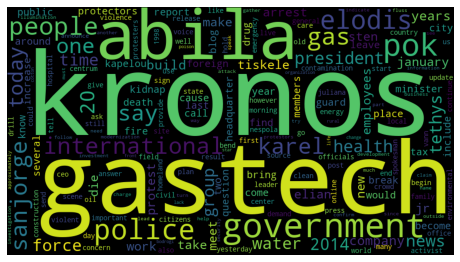

In [8]:
# https://colab.research.google.com/github/gal-a/blog/blob/master/docs/notebooks/nlp/nlp_tf-idf_clustering.ipynb#scrollTo=EbAMAIFFV_xh

# Build tf-idf vectorizer and related variables from the input documents
# to support both unigrams and bigrams use: ngram_range=(1,2)
def build_vectorizer(documents, ngram_range=(1,1), max_df=1.0, min_df=1, stop_words=None, max_features=None):   # default CountVectorizer parameter values
    '''
    (i) Build count_vectorizer from the documents and fit the documents  
    (ii) Build TF (Term Frequency) from the documents, this is a sparse version of the bag-of-words  
    (iii) Build bag-of-words in two steps: fit, transform  
    (iv) Get feature names and build dataframe version of the bag-of-words  
    (v) Use TfidfTransformer to transform bag_of_words into TF-IDF matrix (Term Frequency - Inverse Document Frequency)  
    (vi) Find most popular words and highest weights  
    (vii) Build word weights as a list and sort them  
    (viii) Calculate cosine similarity of all documents with themselves  
    (ix) Calculate distance matrix of documents  
    
    Note:
    The TF_IDF matrix can be built directly with 'TfidfVectorizer' instead of using 'CountVectorizer' followed by 'TfidfTransformer'
    
    Return:
    cvec: CountVectorizer
    tf: Term Frequencies
    tfidf: TF-IDF matrix 
    feature_names: Feature names in TF-IDF
    df_bag_of_words: Bag of words from the sparse Term Frequencies
    df_weights: Most popular words, word counts and highest weights
    cos_sim: Cosine similarity of all documents with themselves
    samp_dist: Distance matrix of documents
    '''
    
    # Build CountVectorizer from the documents and fit the documents
    count_vectorizer = CountVectorizer(ngram_range=ngram_range, max_df=max_df, min_df=min_df, stop_words=stop_words, max_features=max_features)
    
    # Build TF (Term Frequencies) from the documents, this is a sparse version of the bag-of-words
    tf = count_vectorizer.fit_transform(documents)  # note that the LDA transform needs this for its clustering model (explained below)

    # Build bag-of-words in two steps: fit, transform
    cvec = count_vectorizer.fit(documents)
    bag_of_words = cvec.transform(documents)
    
    # Get feature names and build dataframe version of the bag-of-words
    feature_names = cvec.get_feature_names()
    df_bag_of_words = pd.DataFrame(bag_of_words.todense(), columns=feature_names)
    
    # Use TfidfTransformer to transform bag_of_words into TF-IDF matrix (Term Frequency - Inverse Document Frequency)
    transformer = TfidfTransformer()
    tfidf = transformer.fit_transform(bag_of_words)

    # Find most popular words, word counts and highest weights
    word_cnts = np.asarray(bag_of_words.sum(axis=0)).ravel().tolist()  # for each word in column, sum all row counts
    df_cnts = pd.DataFrame({'word': feature_names, 'count': word_cnts})
    df_cnts = df_cnts.sort_values('count', ascending=False)

    # Build word weights as a list and sort them (the dataframe below also contains the counts)
    weights = np.asarray(tfidf.mean(axis=0)).ravel().tolist()
    df_weights = pd.DataFrame({'word': feature_names, 'weight': weights})
    df_weights = df_weights.sort_values('weight', ascending=False)

    df_weights = df_weights.merge(df_cnts, on='word', how='left')
    df_weights = df_weights[['word', 'count', 'weight']]

    # Calc cosine similarity of all documents with themselves
    cos_sim = metrics.pairwise.cosine_similarity(tfidf, tfidf)

    # Calc distance matrix of documents
    samp_dist = 1 - cos_sim

    return cvec, tf, tfidf, feature_names, df_bag_of_words, df_weights, cos_sim, samp_dist
  
# Build TF-IDF matrices
cvec, tf, tfidf, feature_names, df_bag_of_words, df_weights, cos_sim, samp_dist = build_vectorizer(articles6)


def word_cloud(df_weights, n_top_words=20, is_print=True, is_plot=True):
    '''
    Build a word cloud
    '''
    s_word_freq = pd.Series(df_weights['count'])
    s_word_freq.index = df_weights['word']
    di_word_freq = s_word_freq.to_dict()
    cloud = wordcloud.WordCloud(width=900, height=500).generate_from_frequencies(di_word_freq)
    
    if is_print:
        print(df_weights.iloc[:n_top_words,:])
    
    if is_plot:
        plt.imshow(cloud)
        plt.axis('off')
        plt.show()
    
    return cloud
    
# Build word cloud
print("Word cloud based on all categories:")
cloud_all = word_cloud(df_weights, is_print=True)

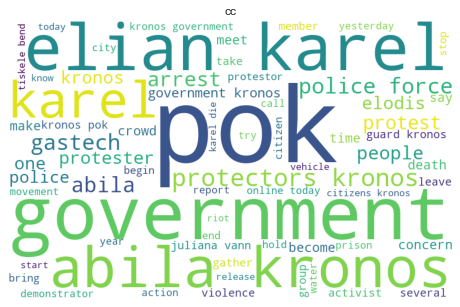

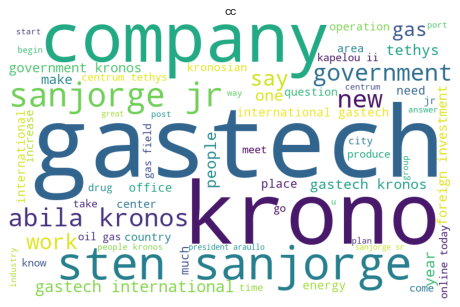

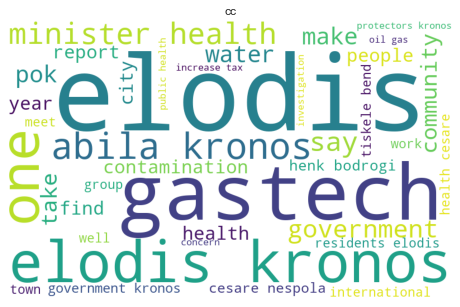

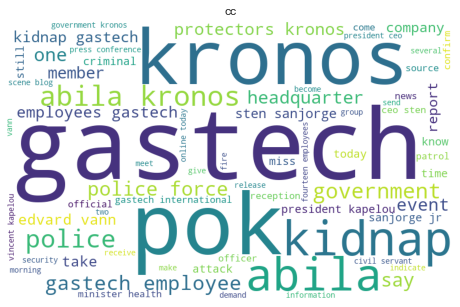

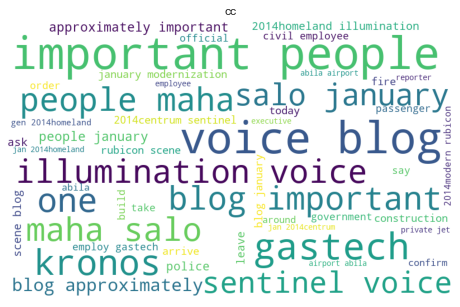

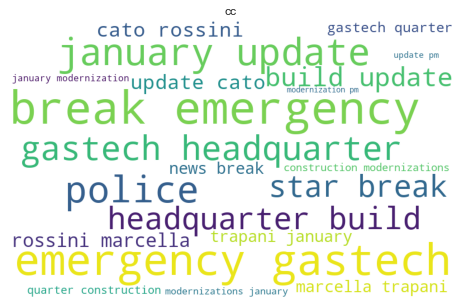

In [42]:
# https://machinelearninggeek.com/text-clustering-clustering-news-articles/
from nltk.tokenize import RegexpTokenizer
# Initialize regex tokenizer
tokenizer = RegexpTokenizer(r'\w+')

# # Vectorize document using TF-IDF
tf_idf_vect = TfidfVectorizer(lowercase=True,
                        stop_words='english',
                        ngram_range = (1,1),
                        tokenizer = tokenizer.tokenize)

# Fit and Transfrom Text Data
X_train_counts = tf_idf_vect.fit_transform(articles6)

# Create Kmeans object and fit it to the training data 
kmeans = KMeans(n_clusters=6).fit(X_train_counts)

# Get the labels using KMeans
pred_labels = kmeans.labels_

def word_cloud(text,wc_title,wc_file_name='wordcloud.jpeg'):
    # Create stopword list
    stopword_list = set(STOPWORDS) 

    # Create WordCloud 
    word_cloud = WordCloud(width = 800, height = 500, 
                           background_color ='white', 
                           stopwords = stopword_list, 
                           min_font_size = 14).generate(text) 

    # Set wordcloud figure size
    plt.figure(figsize = (8, 6)) 
    
    # Set title for word cloud
    plt.title(wc_title)
    
    # Show image
    plt.imshow(word_cloud) 

    # Remove Axis
    plt.axis("off")  

    # save word cloud
    plt.savefig(wc_file_name,bbox_inches='tight')

    # show plot
    plt.show()

df=pd.DataFrame({"text":articles6,"labels":pred_labels})


for i in df.labels.unique():
    new_df=df[df.labels==i]
    text="".join(new_df.text.tolist())
    word_cloud(text, 'cc')

In [10]:
z = []
for article in articles6:
    z.append(article.split())

uniqueWords = {x for l in z for x in l}

nrDocs = len(articles6)
nrUniqueWords = len(uniqueWords)

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
tr_idf_model  = TfidfVectorizer()
tf_idf_vector = tr_idf_model.fit_transform(articles6).toarray()
words_set = tr_idf_model.get_feature_names_out()
df_tf_idf = pd.DataFrame(tf_idf_vector, columns = words_set)
# compute and print the cosine similarity matrix
cosine_sim = cosine_similarity(tf_idf_vector, tf_idf_vector)
cosine_sim

array([[1.    , 0.0219, 0.0434, ..., 0.0381, 0.0836, 0.0251],
       [0.0219, 1.    , 0.0172, ..., 0.    , 0.0062, 0.02  ],
       [0.0434, 0.0172, 1.    , ..., 0.0138, 0.0417, 0.0105],
       ...,
       [0.0381, 0.    , 0.0138, ..., 1.    , 0.0095, 0.1473],
       [0.0836, 0.0062, 0.0417, ..., 0.0095, 1.    , 0.0081],
       [0.0251, 0.02  , 0.0105, ..., 0.1473, 0.0081, 1.    ]])